<a href="https://colab.research.google.com/github/akhilvydyula/Sentiment-Analysis-Hackathon/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

     |████████████████████████████████| 69.2 MB 4.6 kB/s 


**approaches**

1.embeddings for review text with roberta base

2.embeddings for author & review with roberta base

3.ID with min,max,count with embeddings review& author roberta base









In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")
import re

In [ ]:
import re

train = pd.read_csv("https://raw.githubusercontent.com/akhilvydyula/Sentiment-Analysis-Hackathon/main/train.csv",nrows=3000)
test = pd.read_csv("https://raw.githubusercontent.com/akhilvydyula/Sentiment-Analysis-Hackathon/main/test.csv")

In [ ]:
train.head()

,ID,author,Review,Sentiment
0,39467,rayinstirling,Today I'm working on my &quot;Quirky Q&quot; c...,2
1,30154,DirtyRose17,@ShannonElizab dont ya know? people love the h...,1
2,16767,yoliemichelle,ughhh rejected from the 09 mediation program. ...,0
3,9334,jayamelwani,@petewentz im so jealous. i want an octo drive,0
4,61178,aliisanoun,I remember all the hype around this movie when...,0


In [ ]:
train['author'].nunique()

27996

In [ ]:
test.head()

,ID,author,Review
0,29536,nathantbaker,@amyswarren ahhh yay! I'm getting into it. Kno...
1,13442,Umatter2Chtr,@DeliverImHungry You are right. If you ordere...
2,54697,bella_cullen_4,I'd heard a lot of bad things about this film ...
3,7007,marviemorales,"I miss the old... HA, HA. I can't tell that pe..."
4,34410,phaoloo,@dharshana anytime


In [ ]:
def clean(x):
  x = re.sub(r'@\w+'," ",x)
  x = re.sub(r'[^a-zA-Z]'," ",x)
  x = re.sub(r' [a-zA-Z]{1} '," ",x)
  return x


merge = pd.concat([train,test]).reset_index(drop=True)
merge["Review_word_len"] = merge.apply(lambda x:len(re.findall(r"\w+",x['Review'])),axis=1)

#merge["author_word_len"] = merge.apply(lambda x:len(re.findall(r"\w+",x['author'])),axis=1)
#m = merge.groupby('Product_Type')['description_word_len'].agg(['mean','max',"min"])
#merge = merge.merge(m,on='Product_Type',how="left")

#m = merge.groupby('ID')['ID'].agg(['mean','max',"min"])
#merge = merge.merge(m,on='ID',how="left")

merge["Review"] = merge.apply(lambda x:clean(x['Review']),axis=1)
#merge["author"] = merge.apply(lambda x:clean(x['author']),axis=1)

merge

,ID,author,Review,Sentiment,Review_word_len
0,39467,rayinstirling,Today m working on my quot Quirky quot cue or maybe it will become concerto,2.0,18
1,30154,DirtyRose17,dont ya know people love the human society,1.0,9
2,16767,yoliemichelle,ughhh rejected from the mediation program SUCKSSSS,0.0,8
3,9334,jayamelwani,im so jealous want an octo drive,0.0,9
4,61178,aliisanoun,I remember all the hype around this movie when Aaliyah was killed Being fan of Ms Rice novels ...,0.0,592
...,...,...,...,...,...
21895,46435,nnurse,This show comes up with interesting locations as fast as the travel channel It is billed as rea...,NaN,232
21896,30492,___shannon,haha love you too aimeeeeeee,NaN,6
21897,4844,davejlewis,another rainy day,NaN,3
21898,14932,awaisnaseer,wanted to sleep but friend from Denmark just poked me on IM,NaN,13


In [ ]:
merge.isnull().sum()

ID                     0
author                 0
Review                 0
Sentiment          18900
Review_word_len        0
dtype: int64

In [ ]:
train = merge[~merge.Sentiment.isna()]
test = merge[merge.Sentiment.isna()]
test.drop("Sentiment",axis=1,inplace=True)

In [ ]:
!pip install transformers
!pip install -U sentence-transformers

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
import tokenizers
print('TF version',tf.__version__)

TF version 2.5.0


In [ ]:
from sentence_transformers import SentenceTransformer
base_embedder = SentenceTransformer('roberta-large-nli-stsb-mean-tokens')

In [ ]:
from sentence_transformers import SentenceTransformer
large_embedder = SentenceTransformer('roberta-large-nli-stsb-mean-tokens')

In [ ]:
%%time
sentence_embeddings = large_embedder.encode(merge.Review.values.tolist(),batch_size=128,show_progress_bar=True)


CPU times: user 4min 6s, sys: 796 ms, total: 4min 7s
Wall time: 4min 4s


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics  import log_loss
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier

In [ ]:
finaldata = pd.DataFrame(sentence_embeddings)
finaldata.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.824153,0.35232,-0.748976,-1.382072,-0.102123,-0.526272,-0.24395,0.06897,0.230075,-0.645329,0.47475,1.005676,1.017554,0.361311,-1.432837,-0.917285,0.949754,-0.329427,-0.170884,-0.568669,0.316037,1.634148,0.318372,0.94041,0.7344,-1.40018,-0.658861,-1.064679,0.412259,0.002448,-0.353463,1.440209,0.660782,1.102409,-0.79553,-0.454549,0.015496,-0.697331,1.173303,-0.42173,...,-0.871503,0.943163,-0.319441,-0.300014,-0.129621,0.670451,-0.588799,-0.126917,-0.625347,-1.223798,-0.471721,-0.433816,0.716238,-0.611823,-0.750222,-0.168255,1.246253,0.087629,-0.715616,0.927364,-0.187772,-1.834699,0.827573,0.196654,1.457511,1.373616,0.112632,-1.94003,0.213646,0.752191,-1.492469,-0.526526,-0.3184,-0.597415,0.720929,0.743735,0.96853,-0.481373,-1.099309,0.398219


In [ ]:
for i in ["Sentiment","Review_word_len","ID","author"]:
  finaldata[i] = merge[i].values
finaldata.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,Sentiment,Review_word_len,ID,author
0,0.824153,0.352320,-0.748976,-1.382072,-0.102123,-0.526272,-0.243950,0.068970,0.230075,-0.645329,0.474750,1.005676,1.017554,0.361311,-1.432837,-0.917285,0.949754,-0.329427,-0.170884,-0.568669,0.316037,1.634148,0.318372,0.940410,0.734400,-1.400180,-0.658861,-1.064679,0.412259,0.002448,-0.353463,1.440209,0.660782,1.102409,-0.795530,-0.454549,0.015496,-0.697331,1.173303,-0.421730,...,-0.129621,0.670451,-0.588799,-0.126917,-0.625347,-1.223798,-0.471721,-0.433816,0.716238,-0.611823,-0.750222,-0.168255,1.246253,0.087629,-0.715616,0.927364,-0.187772,-1.834699,0.827573,0.196654,1.457511,1.373616,0.112632,-1.940030,0.213646,0.752191,-1.492469,-0.526526,-0.318400,-0.597415,0.720929,0.743735,0.968530,-0.481373,-1.099309,0.398219,2.0,18,39467,rayinstirling
1,-0.365027,-0.455560,0.063664,0.229499,0.642083,-1.222371,-1.316943,2.267829,-0.248501,0.134820,0.014761,0.646918,1.656562,2.222751,-0.647111,0.540658,0.432775,0.229531,1.685157,0.205077,1.379554,-0.837953,0.804142,0.577721,1.321760,2.040909,0.427834,-1.561678,0.077224,-1.001866,-0.516697,0.749740,0.085857,0.829906,-0.972794,-1.725018,-0.511566,0.775273,-1.629585,0.109714,...,0.433604,0.548014,-0.386930,-0.178515,0.605266,-0.807350,0.582261,-0.394286,0.073857,-0.636480,0.668325,-0.877184,-0.646081,-0.254194,-1.469041,-0.957992,0.170138,1.385530,-0.056644,-0.171576,0.264515,-0.224109,0.370864,-1.256727,0.242963,-0.101058,0.283684,0.676214,-1.079959,0.911218,-1.151905,0.142632,-1.039781,0.845404,-2.171083,0.394195,1.0,9,30154,DirtyRose17
2,0.470430,-0.814869,-0.654707,0.310867,0.062930,1.094433,-0.067153,0.374165,-0.874635,0.312836,-0.996025,1.716838,-1.182448,-0.539837,0.845099,0.159614,-0.385408,-0.510257,0.633683,-0.038030,1.319672,1.422469,1.629409,1.228919,0.717547,0.466052,0.891204,0.187200,-0.992079,-1.578991,1.082841,-0.965059,0.201593,1.234597,-1.285377,0.369831,0.582699,-0.780916,0.147570,0.961477,...,-1.277725,-0.524999,-1.011718,-2.372612,0.931450,-0.745429,1.977541,0.089862,-0.047260,0.909658,0.378885,0.158644,-0.399923,-2.928154,-0.759542,0.566346,-1.090921,-0.774355,-0.916509,0.469617,1.078992,-0.501788,-0.862588,-1.580382,0.353025,0.646424,0.907429,0.724879,-0.224136,-0.443711,1.286409,1.675535,0.096771,-0.510079,-1.320317,-0.788033,0.0,8,16767,yoliemichelle
3,-0.774818,0.889622,-0.249607,-0.488065,0.238003,-0.847475,-0.542272,1.832367,0.343758,0.016978,0.906989,-0.188549,-0.063417,0.966592,-0.364308,-1.692365,-0.169939,0.221202,-0.860601,0.203138,0.222056,-1.861319,-0.217070,1.029011,-0.655179,0.445696,0.026310,-1.356015,-0.316572,-0.332568,0.192281,1.171384,-1.498015,1.017528,-0.641334,-0.285898,1.496847,-1.131026,0.101479,0.800017,...,-0.767734,1.164548,-0.799614,-1.878745,-0.114266,-0.504970,0.580700,-0.909164,0.284295,1.012899,0.260162,-0.416058,-0.062312,-0.822287,-1.217873,0.610652,0.001265,0.627588,-0.668081,0.443790,-0.165298,0.462916,-0.143801,-0.605793,-0.803195,0.277942,-0.169049,0.149176,-0.487342,1.376661,-0.573630,0.541417,0.173780,-0.383649,0.625949,-0.364960,0.0,9,9334,jayamelwani
4,-0.304774,1.053547,-0.165260,0.150422,0.755614,-0.621359,0.162838,-1.074244,0.238580,-0.120688,0.798485,-1.951121,0.262890,1.281565,-0.397021,-1.229310,0.637945,-0.886302,1.206004,-0.758420,-0.133013,-0.391584,-1.830096,-0.540288,-0.461200,0.428935,-0.752942,-0.786581,0.409664,-0.375757,0.568954,0.400132,0.364826,0.979162,-0.378190,-0.104785,0.028977,-1.695551,-1.490118,0.082913,...,-0.016241,0.373379,-0.148316,-0.726972,0.394487,-0.927164,1.874971,-0.271489,-0.971971,-0.005267,-1.333934,-0.006860,0.675803,0.635264,-1.054229,0.607437,0.514243,-0.350544,0.023689,-0.683086,0.644134,0.679272,-1.000620,-0.073471,-0.509851,-0.127764,0.246690,-0.689567,-0.029034,0.6755

In [ ]:
train = finaldata[~finaldata.Sentiment.isna()]
test = finaldata[finaldata.Sentiment.isna()]
test.drop("Sentiment",axis=1,inplace=True)

0:	learn: 0.5792593	test: 0.5700000	best: 0.5700000 (0)	total: 44.7ms	remaining: 1d 13h 15m 51s
400:	learn: 0.8974074	test: 0.6466667	best: 0.6500000 (6)	total: 9.83s	remaining: 20h 25m 1s
800:	learn: 0.9788889	test: 0.6466667	best: 0.6600000 (481)	total: 18.9s	remaining: 19h 38m 21s
1200:	learn: 0.9966667	test: 0.6500000	best: 0.6600000 (481)	total: 27.9s	remaining: 19h 21m 31s
bestTest = 0.66
bestIteration = 481
Shrink model to first 482 iterations.
0.8166625652066456
------------------------------------------------------------------------------------------------------------------------------------------------------


0:	learn: 0.5792593	test: 0.5766667	best: 0.5766667 (0)	total: 26.6ms	remaining: 22h 7m 51s
400:	learn: 0.9070370	test: 0.6933333	best: 0.7000000 (167)	total: 9.53s	remaining: 19h 48m 14s
800:	learn: 0.9800000	test: 0.7066667	best: 0.7166667 (707)	total: 18.7s	remaining: 19h 26m 15s
1200:	learn: 0.9970370	test: 0.7100000	best: 0.7166667 (707)	total: 27.9s	remaining: 19h 20m 33s
1600:	learn: 0.9977778	test: 0.6966667	best: 0.7166667 (707)	total: 37s	remaining: 19h 15m
bestTest = 0.7166666667
bestIteration = 707
Shrink model to first 708 iterations.
0.7250343484041694
------------------------------------------------------------------------------------------------------------------------------------------------------


0:	learn: 0.5629630	test: 0.5633333	best: 0.5633333 (0)	total: 26.2ms	remaining: 21h 52m 7s
400:	learn: 0.9003704	test: 0.6966667	best: 0.7133333 (243)	total: 9.51s	remaining: 19h 46m 4s
800:	learn: 0.9814815	test: 0.6866667	best: 0.7133333 (243)	total: 18.7s	remaining: 19h 24m 46s
1200:	learn: 0.9981481	test: 0.6900000	best: 0.7133333 (243)	total: 27.7s	remaining: 19h 11m 37s
bestTest = 0.7133333333
bestIteration = 243
Shrink model to first 244 iterations.
0.7007219323617377
------------------------------------------------------------------------------------------------------------------------------------------------------


0:	learn: 0.5885185	test: 0.5066667	best: 0.5066667 (0)	total: 25.5ms	remaining: 21h 17m 9s
400:	learn: 0.9000000	test: 0.6433333	best: 0.6666667 (282)	total: 9.57s	remaining: 19h 52m 54s
800:	learn: 0.9788889	test: 0.6566667	best: 0.6666667 (282)	total: 18.9s	remaining: 19h 40m 9s
1200:	learn: 0.9981481	test: 0.6566667	best: 0.6700000 (1107)	total: 28.2s	remaining: 19h 33m 54s
1600:	learn: 0.9985185	test: 0.6600000	best: 0.6700000 (1107)	total: 37.3s	remaining: 19h 23m 58s
2000:	learn: 0.9988889	test: 0.6666667	best: 0.6700000 (1107)	total: 46.6s	remaining: 19h 22m 48s
bestTest = 0.67
bestIteration = 1107
Shrink model to first 1108 iterations.
0.7653263651968594
------------------------------------------------------------------------------------------------------------------------------------------------------


0:	learn: 0.5803704	test: 0.5633333	best: 0.5633333 (0)	total: 28.9ms	remaining: 1d 6m 20s
400:	learn: 0.8981481	test: 0.7000000	best: 0.7266667 (193)	total: 9.62s	remaining: 19h 59m 40s
800:	learn: 0.9803704	test: 0.7166667	best: 0.7266667 (193)	total: 18.9s	remaining: 19h 39m 36s
bestTest = 0.7266666667
bestIteration = 193
Shrink model to first 194 iterations.
0.7020231882832606
------------------------------------------------------------------------------------------------------------------------------------------------------


0:	learn: 0.5859259	test: 0.5866667	best: 0.5866667 (0)	total: 25.7ms	remaining: 21h 25m 8s
400:	learn: 0.8988889	test: 0.7000000	best: 0.7000000 (218)	total: 9.49s	remaining: 19h 42m 55s
800:	learn: 0.9770370	test: 0.6900000	best: 0.7000000 (218)	total: 18.6s	remaining: 19h 20m 18s
1200:	learn: 0.9970370	test: 0.6766667	best: 0.7000000 (218)	total: 27.7s	remaining: 19h 12m 5s
bestTest = 0.7
bestIteration = 218
Shrink model to first 219 iterations.
0.7356483778305861
------------------------------------------------------------------------------------------------------------------------------------------------------


0:	learn: 0.5659259	test: 0.5600000	best: 0.5600000 (0)	total: 27.7ms	remaining: 23h 6m
400:	learn: 0.9044444	test: 0.7233333	best: 0.7400000 (122)	total: 9.7s	remaining: 20h 9m 46s
800:	learn: 0.9814815	test: 0.7366667	best: 0.7400000 (122)	total: 18.9s	remaining: 19h 36m 34s
1200:	learn: 0.9977778	test: 0.7333333	best: 0.7466667 (926)	total: 28s	remaining: 19h 25m 43s
1600:	learn: 0.9981481	test: 0.7300000	best: 0.7466667 (926)	total: 37s	remaining: 19h 15m 18s
bestTest = 0.7466666667
bestIteration = 926
Shrink model to first 927 iterations.
0.6686314074071298
------------------------------------------------------------------------------------------------------------------------------------------------------


0:	learn: 0.5829630	test: 0.5433333	best: 0.5433333 (0)	total: 23.9ms	remaining: 19h 53m 51s
400:	learn: 0.9037037	test: 0.6233333	best: 0.6533333 (51)	total: 9.48s	remaining: 19h 41m 43s
800:	learn: 0.9792593	test: 0.6266667	best: 0.6533333 (51)	total: 18.6s	remaining: 19h 22m 37s
bestTest = 0.6533333333
bestIteration = 51
Shrink model to first 52 iterations.
0.823289906849051
------------------------------------------------------------------------------------------------------------------------------------------------------


0:	learn: 0.5825926	test: 0.5600000	best: 0.5600000 (0)	total: 34.8ms	remaining: 1d 5h 1m 14s
400:	learn: 0.8970370	test: 0.7200000	best: 0.7266667 (121)	total: 9.68s	remaining: 20h 6m 58s
800:	learn: 0.9777778	test: 0.7133333	best: 0.7366667 (475)	total: 18.9s	remaining: 19h 39m 53s
1200:	learn: 0.9962963	test: 0.7166667	best: 0.7366667 (475)	total: 28s	remaining: 19h 26m 1s
bestTest = 0.7366666667
bestIteration = 475
Shrink model to first 476 iterations.
0.6915906867304994
------------------------------------------------------------------------------------------------------------------------------------------------------


0:	learn: 0.5751852	test: 0.6133333	best: 0.6133333 (0)	total: 25.5ms	remaining: 21h 16m 44s
400:	learn: 0.8981481	test: 0.7000000	best: 0.7133333 (78)	total: 9.52s	remaining: 19h 47m 19s
800:	learn: 0.9807407	test: 0.7033333	best: 0.7166667 (610)	total: 18.7s	remaining: 19h 26m 50s
1200:	learn: 0.9970370	test: 0.7033333	best: 0.7166667 (610)	total: 28s	remaining: 19h 23m 56s
1600:	learn: 0.9981481	test: 0.7066667	best: 0.7166667 (610)	total: 37.1s	remaining: 19h 17m 48s
bestTest = 0.7166666667
bestIteration = 610
Shrink model to first 611 iterations.
0.7139623141848935
------------------------------------------------------------------------------------------------------------------------------------------------------
Mean Score : 0.7342891092454833
Min Score : 0.6686314074071298
Max Score : 0.823289906849051


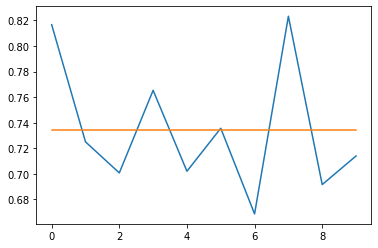

In [ ]:
X = train.drop(["Sentiment"],axis=1)
Y = train[['Sentiment']]

params = {
    "od_type":"Iter",
    "od_wait":150,
    "iterations":3000000,
    'learning_rate':0.03590,
    "eval_metric":"Accuracy",
    "task_type":"GPU",
    "boosting_type":"Plain"
}

best_score = np.inf
scores = []

folds_large = KFold(n_splits=10,shuffle=True,random_state=1200)

for train_idx , test_idx in folds_large.split(X,Y):
  train_set = (X.iloc[train_idx],Y.iloc[train_idx])
  test_set = (X.iloc[test_idx],Y.iloc[test_idx])

  model = CatBoostClassifier(**params)
  model.fit(*train_set,
            cat_features = ["author"],
            eval_set=[test_set],early_stopping_rounds=1000,verbose=400)

  score = log_loss(test_set[1].values,model.predict_proba(test_set[0]))
  print(score)
  scores.append(score)
  

  if score < best_score:
    best_score = score
    best_model = model

  print("---"*50)

print(f"Mean Score : {np.array(scores).mean()}")
print(f"Min Score : {np.array(scores).min()}")
print(f"Max Score : {np.array(scores).max()}")

plt.plot(scores)
plt.plot(np.arange(len(scores)),[np.array(scores).mean()]*len(scores),)
plt.show()

model_large = best_model

In [ ]:
pd.set_option("display.max_colwidth",100)
pd.set_option("display.max_rows",150)
m = pd.DataFrame(list(zip(X.columns,model_large.feature_importances_))).sort_values(1,ascending=False)
m

,0,1
1025,ID,5.314131
278,278,1.280067
143,143,1.108163
655,655,1.040488
762,762,0.866813
...,...,...
380,380,0.000000
589,589,0.000000
588,588,0.000000
406,406,0.000000


In [ ]:
test.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,Review_word_len,author_word_len,mean,max,min,ID
44100,0.745176,-0.676836,-0.051447,1.968919,1.265744,1.693835,0.029933,-1.240204,0.934193,-0.075846,-1.274072,1.107055,-0.391580,-0.516813,0.515169,-2.206065,1.095466,-0.533271,-0.273653,0.137508,0.320767,0.721511,1.934888,-0.634872,0.754308,0.088769,1.194273,0.780533,-1.448006,-0.663340,-2.495598,-1.619974,2.075023,1.164396,1.284146,1.787066,-0.715154,-1.109128,0.837347,0.602609,...,-0.071780,-3.973341,0.693342,0.126287,-0.344820,-0.002858,-0.481717,-1.373790,-0.139628,0.558871,0.191140,-0.208571,0.485539,0.272242,0.358461,1.974443,-0.915820,1.043814,-0.935467,-0.943318,0.151307,0.513304,-1.053934,1.015281,0.899375,-0.365517,-0.729451,-0.251938,0.582634,1.140303,-2.274660,-1.575945,0.982248,0.021802,12,1,29536,29536,29536,29536
44101,-0.322476,-0.804887,-0.065550,-0.231690,0.391872,0.172424,0.113885,-1.403361,-1.009889,-0.476789,-1.245439,0.372856,0.254744,1.475593,0.708636,-0.147464,-1.475647,0.546941,0.406814,-0.521626,-0.193943,0.384512,-0.444835,0.246216,0.290235,-0.033461,-0.330014,0.556403,0.641487,-0.855914,-0.825456,-1.080143,-0.238762,-0.026030,0.050337,0.933512,1.000573,-1.084002,-1.244545,0.795201,...,-0.674889,0.287866,0.204284,-2.419436,0.282268,0.276376,-0.563820,-2.087152,1.191963,-0.736988,-0.031997,1.355055,-0.276101,0.096374,-0.924806,-0.451451,-1.021361,-0.554931,1.015811,-1.595260,-0.836661,-0.494344,0.697123,0.003202,0.292595,-0.882890,-0.830279,1.412081,1.510109,0.022678,0.604418,-0.883560,0.664785,0.979719,22,1,13442,13442,13442,13442


In [ ]:
submission = pd.DataFrame(model_large.predict_proba(test))
submission.columns = ["Negative_0","Neutral_1","Positive_2"]
submission.to_excel("koi.xlsx",index=False)
submission

,Negative_0,Neutral_1,Positive_2
0,0.175026,0.104620,0.720354
1,0.784872,0.151945,0.063182
2,0.695157,0.005820,0.299023
3,0.383285,0.181303,0.435412
4,0.095661,0.553333,0.351007
...,...,...,...
18895,0.495160,0.027485,0.477356
18896,0.068127,0.042807,0.889066
18897,0.809170,0.120646,0.070184
18898,0.682764,0.115733,0.201503


In [ ]:
a  = pd.read_excel("mysubm3.xlsx")
a.isnull().sum()

Negative_0    0
Neutral_1     0
Positive_2    0
dtype: int64

In [ ]:
from sentence_transformers import SentenceTransformer
base_embedder = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')

In [ ]:
%%time
base_embeddings = base_embedder.encode(merge.Review.values.tolist(),batch_size=128,show_progress_bar=True)


CPU times: user 4min 53s, sys: 745 ms, total: 4min 54s
Wall time: 4min 46s


In [ ]:
train = data[~data.Sentiment.isna()]
test = data[data.Sentiment.isna()]
test.drop("Sentiment",axis=1,inplace=True)

In [ ]:
X = train.drop(["Sentiment"],axis=1)
Y = train[['Sentiment']]

params = {
    "od_type":"Iter",
    "od_wait":150,
    "iterations":25000,
    'learning_rate':0.0355,
    "eval_metric":"Accuracy",
    "task_type":"GPU",
    # "boosting_type":"Plain"
}

best_score = np.inf
scores = []

folds_base = KFold(n_splits=5,shuffle=True,random_state=1250)

for train_idx , test_idx in folds_base.split(X,Y):
  train_set = (X.iloc[train_idx],Y.iloc[train_idx])
  test_set = (X.iloc[test_idx],Y.iloc[test_idx])

  model = CatBoostClassifier(**params)
  model.fit(*train_set,
            cat_features = ['Review_word_len'],
            eval_set=[test_set],early_stopping_rounds=500,verbose=200)

  score = log_loss(test_set[1].values,model.predict_proba(test_set[0]))
  print(score)
  scores.append(score)
  

  if score < best_score:
    best_score = score
    best_model = model

  print("---"*50)

print(f"Mean Score : {np.array(scores).mean()}")
print(f"Min Score : {np.array(scores).min()}")
print(f"Max Score : {np.array(scores).max()}")

plt.plot(scores)
plt.plot(np.arange(len(scores)),[np.array(scores).mean()]*len(scores),)
plt.show()

model_base = best_model

In [ ]:
submission = pd.DataFrame(model_base.predict_proba(test))
submission.columns = ["Negative_0","Neutral_1","Positive_2"]
submission.to_excel("submission_base.xlsx",index=False)
submission

In [ ]:
base = pd.read_excel("mysubm.xlsx")
large = pd.read_excel("mysubm2.xlsx")

final = (base+large)/2
final.to_excel("submission.xlsx",index=False)
final


,Negative_0,Neutral_1,Positive_2
0,0.160523,0.140624,0.698853
1,0.724990,0.216739,0.058271
2,0.875998,0.000711,0.123291
3,0.392851,0.168147,0.439002
4,0.311845,0.280341,0.407815
...,...,...,...
18895,0.589932,0.018268,0.391801
18896,0.168543,0.079911,0.751546
18897,0.495654,0.379124,0.125222
18898,0.334126,0.370359,0.295516
